<div class="title">Practical Assignment: Dimensionality Reduction</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Ángela Fernández Pascual - Universidad Autónoma de Madrid</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size when solving the eigenvector problem, the examples used will be simple ones. We recommend the use of `eigs` from `scipy` that computes only the first `k` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors finded should be flipped in terms of their sign to obtain always the same result.
* Data should be centered inside the method (so the data has zero mean, but the std remains the same), being careful to also center the new data points.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

- rbf_kernel realiza de forma interna la operación de la distancia euclidea multiplicado por el valor de gmma $γ(x-y)^2$

- linear_kernel realiza esta operación $x^Ty$

In [4]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler, KernelCenterer
from sklearn.utils.extmath import svd_flip

class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components, kernel=None, gamma=None):
        # Assignment of the hyper-parameters (complete).
        self.n_components = n_components
        self.kernel=kernel
        self.gamma=gamma
        # ...

    def fit(self, X):
        # Computation of the projection direction (complete).
        np.random.seed(100)

        self.X_fit = X
        
        #Selección de la función de kernel deseada
        if self.kernel == "rbf":
           self.kernel = lambda X,Y: rbf_kernel(X, Y, gamma=self.gamma )
        elif self.kernel == "linear":
           self.kernel = lambda X,Y: linear_kernel(X, Y)
        else:
          print("No es una función del kernel válida")
          exit()

        #Se centraliza el kernel
        self.kC=KernelCenterer()
        self.kernelC=self.kC.fit_transform(self.kernel(X,X))

        #Calculamos los autovalores y los autovectores
        self.eigh_vals, self.eigh_vecs = np.linalg.eigh(self.kernelC)

        #Normalizamos los autovectores
        self.eigh_vecs,_ = svd_flip(self.eigh_vecs, np.zeros_like(self.eigh_vecs).T)
        non_zeros = np.flatnonzero(self.eigh_vals)
        self.scaled_alphas = np.zeros_like(self.eigh_vecs)
        self.scaled_alphas[:, non_zeros] = self.eigh_vecs[:, non_zeros] / np.sqrt(self.eigh_vals[non_zeros])
        
        #Se obtiene la misma cantidad de autovectores normalizados que número de componentes
        self.K_pca = np.column_stack([self.scaled_alphas[:,-i] for i in range(1,self.n_components+1)])

        return self


    def transform(self, X):
        # Computation of the projected components (complete).
        if np.array_equal(self.X_fit, X):
          return np.dot(self.kernelC,self.K_pca)
        else:
          return np.dot(self.kC.transform(self.kernel(X,self.X_fit)),self.K_pca)

    def fit_transform(self, X):
        # Computation of the projected components over X just after training with it (complete).
        self.fit(X);
        return self.transform(X)

En nuestra implementación se ha añadido 5 elementos a la clase:
- n_components = Número de dimensiones
- kernel = Tipo de función del núcleo que solo podrá ser lineal y rbf
- gamma

Función fit:
- Se elige la función de núcleo deseada (lineal o rbf)
- Se centralizan los valores transformados por la función del núcleo utilizando la clase kernelCenterer
- Se obtienen los autovalores y los autovectores con el método np.linealg.eigh(). Este método te devuelve los autovalores de forma ascendente con su autovector asociado.
- El siguiente bloque de instrucciones son para normalizar los autovectores. Para ello, se genera la variable scaled_alphass donde se guardará los resultados de este proceso. Antes de todo utilizaremos el método svd_flip() de la librería exmath para asegurarnos obtener una salida determinista.
Para normalizarlos, tendremos que eliminar los autovectores que tienen asociado un autovalor menor o igual que 0 ($α>0$) y realizaremos la división de los elementos de los autovectores por la raiz cuadrada de sus autovalores ($\alpha>0$). 
- Por último, se obtendrá los mayores valores de scaled_alphas, la cantidad de ellos será teniendo en cuenta el número de dimensiones que nos interese más uno y se guarda en la variable kpca. 
Esta función guardará las variables necesarias para la clase y las modificará según los datos dados.

Función transform:
- Esta función multiplica de forma escalar los elementos de kpca (cantidad (n_components) de los mayores valores de scaled_alpha) generados por el método fit de la clase con los datos que les pasemos transformados por la función del núcleo centralizada y lo devuelve. 
Para este método se ha dividido en dos casos, una en el caso de que los datos del fit y la transformación sean los mismos, es decir realizar un fit_transform y otro caso cuando se realiza la transformación con unos datos diferentes, que en este caso habrá que transformarlos con la función del kernel.

Función fit_transform:
Realiza la función fit() con los datos que se le pasen y ejecuta el método transform() con los datos tranformados por función de kernel(kernelC) y su centralización.

# Experiments with KPCA

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

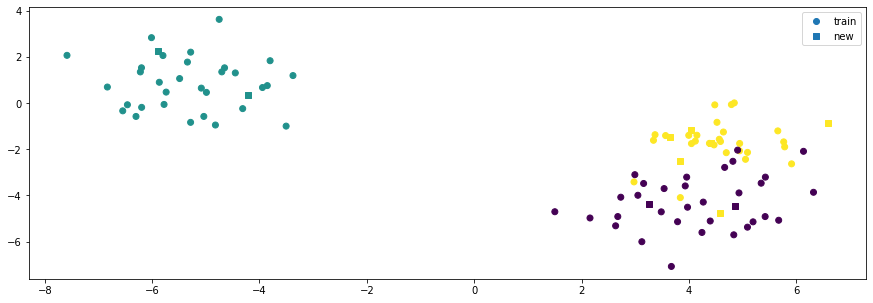

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

**Entrenamientos de los modelos**

In [6]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

kernel = 'linear'
n_components=1

myModel = KPCA(n_components=n_components, kernel='linear')
skModel = PCA(n_components=n_components)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_new = scaler.transform(X_new)

# Training of the models (complete).
myKPCA = myModel.fit_transform(X_train)
skPCA = skModel.fit_transform(X_train)

#Tranform X_new
myKPCA2 = myModel.transform(X_new)
skPCA2 = skModel.transform(X_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


**Comparativa**

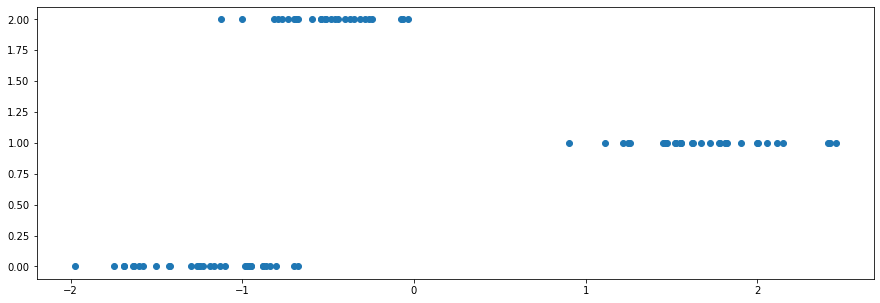

In [7]:
plt.scatter(myKPCA[:,0],y_train, label='train')

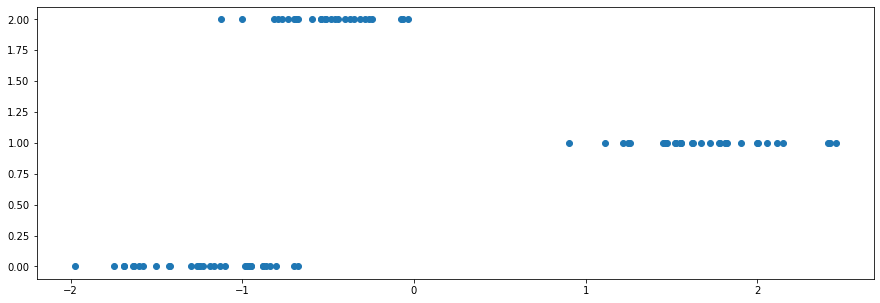

In [8]:
plt.scatter(skPCA[:,0],y_train, label='train')

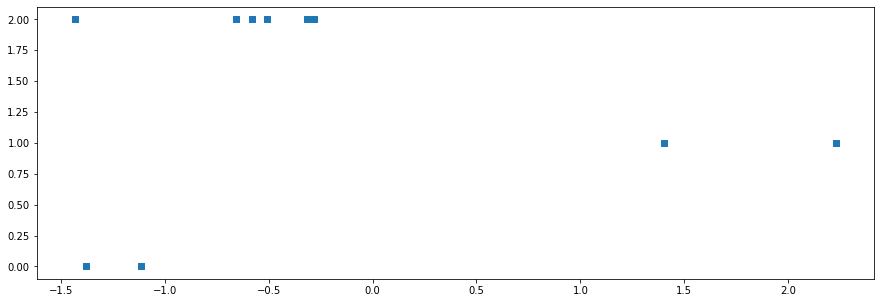

In [9]:
plt.scatter(myKPCA2[:,0],y_new, marker='s', label='new')

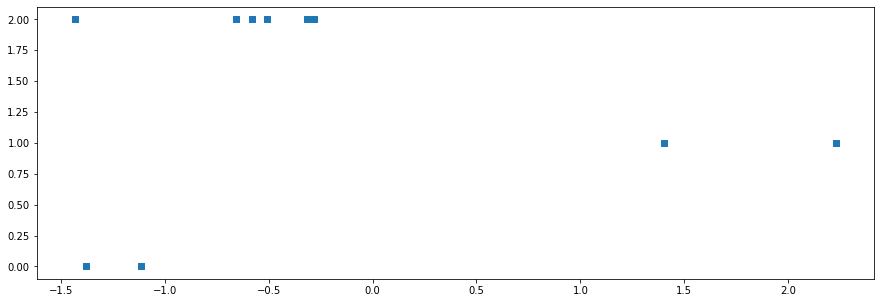

In [10]:
plt.scatter(skPCA2[:,0],y_new, marker='s', label='new')

Las salidas se han comparado hasta el tercer decimal.

In [11]:
np.allclose(myKPCA,skPCA,atol=0.001)

True

Las salidas son iguales con los dos modelos, ya que al utilizar un algoritmo lineal no existe una diferencia real en el uso de cada uno. En el caso, de utilizar un algoritmo que tenga que separar los elemento en un círculo por ejemplo, con el PCA simplemente se dividiría como una recta que se proyecta sobre la dirección de máxima varianza pero sin respetar la curvatura. Lo cual si haría el algoritmo KPCA indicancole la función del núcleo rbf por ejemplo.

<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [12]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=2

# Model definition (complete).
myRBFModel = KPCA(n_components=n_components, kernel='rbf',gamma=0.01)
skRBFModel = KernelPCA(n_components=n_components,kernel="rbf",gamma=0.01)

# Training of the models (complete).
myRBFKPCA = myRBFModel.fit_transform(X_train)
skRBFKPCA = skRBFModel.fit_transform(X_train)

#Tranform X_new
myRBFKPCA2 = myRBFModel.transform(X_new)
skRBFKPCA2 = skRBFModel.transform(X_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


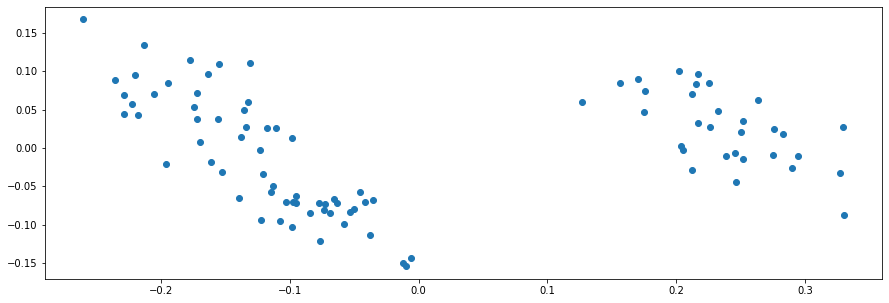

In [13]:
plt.scatter(myRBFKPCA[:,0],skRBFKPCA[:,1], label='train')

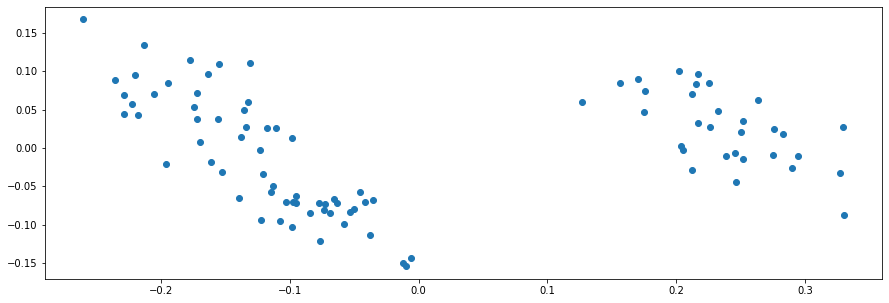

In [14]:
plt.scatter(skRBFKPCA[:,0],skRBFKPCA[:,1], label='train')

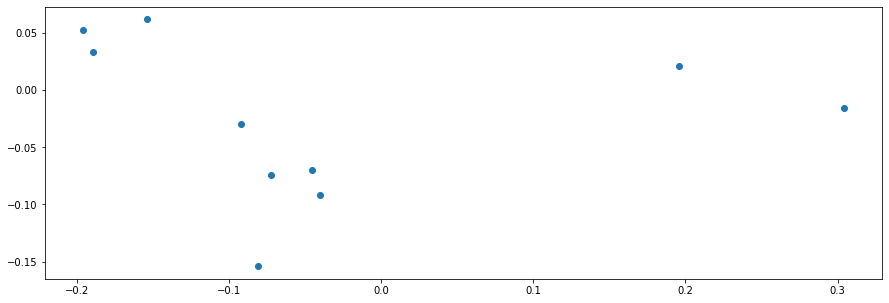

In [15]:
plt.scatter(myRBFKPCA2[:,0],skRBFKPCA2[:,1],label='new')

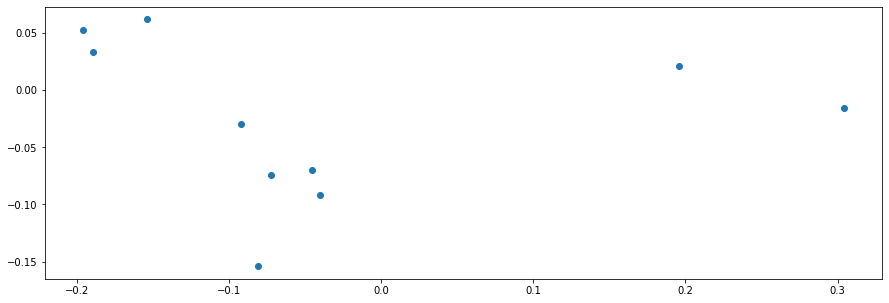

In [16]:
plt.scatter(skRBFKPCA2[:,0],skRBFKPCA2[:,1], label='new')

In [17]:
np.allclose(myRBFKPCA,skRBFKPCA,atol=0.001)

True

In [18]:
np.allclose(np.sort(myRBFModel.K_pca,axis=0),np.sort(skRBFModel.eigenvectors_,axis=0),atol=0.001)

False

El resultado es el mismo, pero los autovectores utilizados por las dos maneras de hacerlo salen distintos.

## Comparing linear kernel against Gaussian kernel

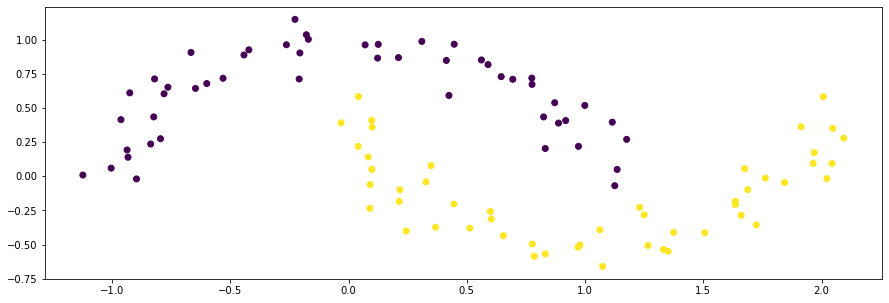

In [19]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

In [23]:
n_components=2

model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf',gamma=0.04)

scaler2 = StandardScaler()
X = scaler2.fit_transform(X)

# Training of the models (complete).
rbfM = model_linear.fit_transform(X)
linearM = model_rbf.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


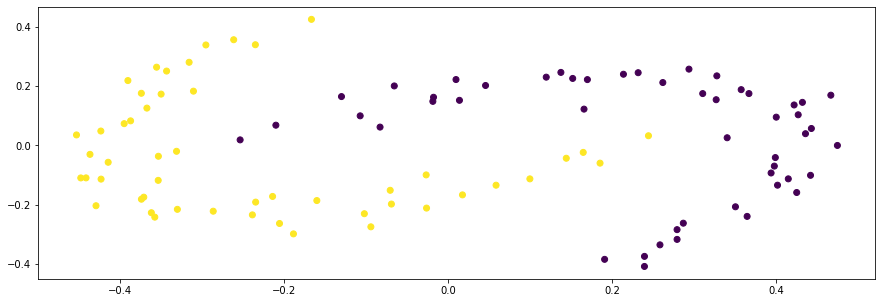

In [21]:
plt.scatter(linearM[:,0], linearM[:,1],c=y)

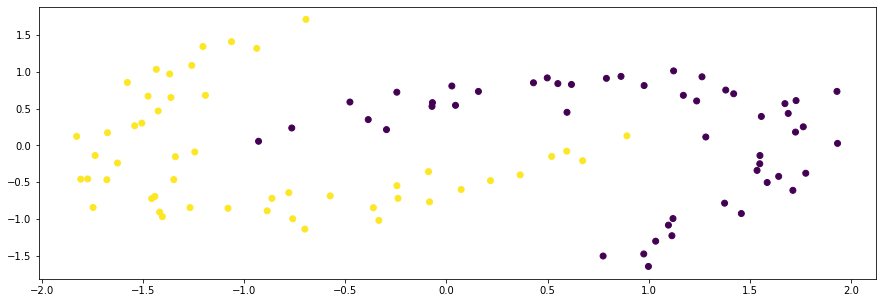

In [22]:
plt.scatter(rbfM[:,0], rbfM[:,1],c=y)

Se observa que en la primera imagen que es la de la transformación lineal, se intenta separar los elementos en dos mitades. Pero en la de la transformación rbf, la separación realiza una curvatura.

**Observar diferentes modelos**

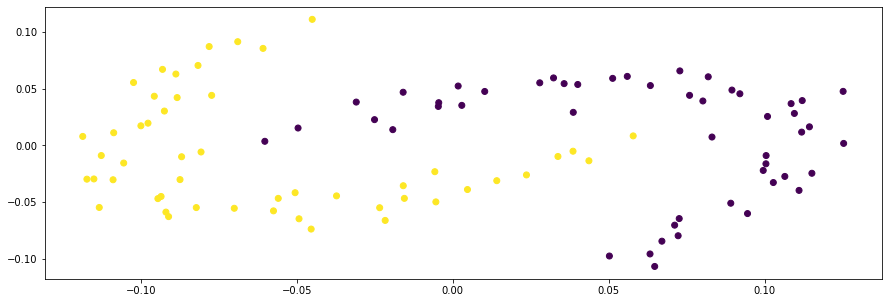

In [27]:
skSigModel = KernelPCA(n_components=n_components,kernel="sigmoid",gamma=0.01)
pruebaSig = skSigModel.fit_transform(X)
plt.scatter(pruebaSig[:,0], pruebaSig[:,1],c=y)

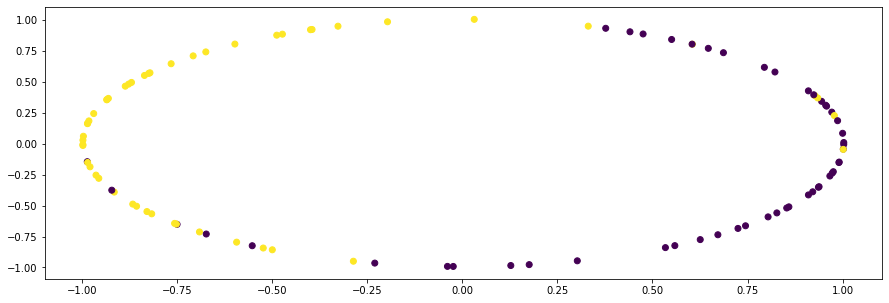

In [28]:
skSigModel = KernelPCA(n_components=n_components,kernel="cosine",gamma=0.01)
pruebaSig = skSigModel.fit_transform(X)
plt.scatter(pruebaSig[:,0], pruebaSig[:,1],c=y)

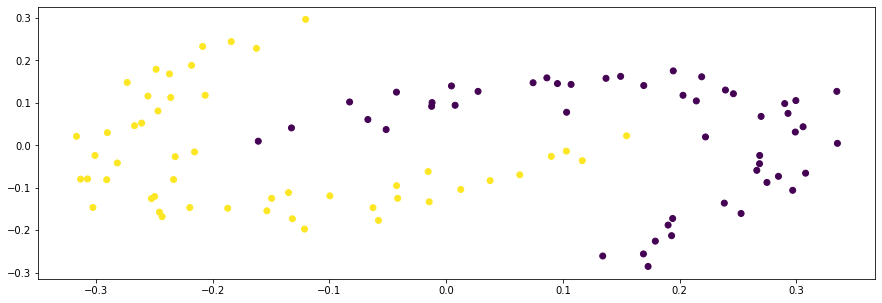

In [30]:
skSigModel = KernelPCA(n_components=n_components,kernel="poly",gamma=0.01)
pruebaSig = skSigModel.fit_transform(X)
plt.scatter(pruebaSig[:,0], pruebaSig[:,1],c=y)

Salvo el modelo cosine, las demás de manera visual son practicamente iguales.